###Task -1

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from astropy.table import Table
import requests

# url = 'https://archive.stsci.edu/'
# response = requests.get(url)
# with open('temp_image.fits', 'wb') as f:
#     f.write(response.content)
fits_image_filename = "hlsp_orion_hst_acs_colorimage_b_v1_drz_sci.fits"
# with fits.open(fits_image_filename, memmap=False) as hdul:
#     hdul.info()
#     image_data = hdul[0].data
#     print(image_data)



hdul = fits.open(fits_image_filename)
hdul.info()
image_data = hdul[0].data
print(image_data)
hdul.close()

In [ ]:
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()
# plt.savfig('M42 Image.png')
plt.show()

In [ ]:
section1 = image_data[3500:4100, 5000:5600]
plt.figure()
plt.imshow(section1, cmap='gray')
plt.colorbar()
# plt.savfig('M42_Image_Section.png')
plt.show()

In [ ]:
Section2 = image_data[3500:3800, 5000:5300]
threshold = np.percentile(Section2, 95)  # Adjust threshold as needed
binary_image = Section2 > threshold
labeled_image, num_objects = label(binary_image, return_num=True)
print(f"Number of objects: {num_objects}")
# 3. Feature Extraction
objects = []
for i in range(1, num_objects + 1):
    region = regionprops(labeled_image)[i - 1]
    x, y = region.centroid
    size = region.area
    luminosity = np.sum(Section2[labeled_image == i])
    objects.append({
        'Object_ID': i,
        'X': x,
        'Y': y,
        'Size': size,
        'Luminosity': luminosity
    })

table = Table(rows=objects)
table.write('objects.csv', format='csv', overwrite=True)


In [ ]:

data = pd.read_csv('objects.csv')
print(data)

In [ ]:
limited_data = data.head(50)
plt.scatter(limited_data['Object_ID'], limited_data['Luminosity'])

# Add labels and title
plt.xlabel('Object_ID')
plt.ylabel('Luminosity')
plt.title('Scatter Plot of ' + 'Object_ID' + ' vs ' + 'Luminosity')

# Show the plot
# plot.savefig('Luminosity_Scatter_Plot.png')
plt.show()

### TASK 2

In [ ]:
!pip install skyfield

In [ ]:
from skyfield.api import Topos, load
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Load TLE data for the Hubble Space Telescope
tle_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=stations&FORMAT=tle'  # Hubble Space Telescope TLE data
satellites = load.tle_file(tle_url)

# Choose the Hubble Space Telescope satellite
satellite = satellites[0]

# Observer's location (Equator)
observer = Topos(latitude_degrees=0, longitude_degrees=0)

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_title(f'Live Location of {satellite.name} with Trail')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)

# Initialize the satellite point and trail
satellite_point, = ax.plot([], [], 'ro', label=f'{satellite.name}', markersize=5)
trail, = ax.plot([], [], 'b-', lw=1, label='Trail')

# Initialize data storage for the trail
trail_longitudes = []
trail_latitudes = []

# Compute satellite position dynamically
ts = load.timescale()

def update(frame):
    global trail_longitudes, trail_latitudes
    t = ts.now()
    geocentric = satellite.at(t)
    subpoint = geocentric.subpoint()
    latitude, longitude = subpoint.latitude.degrees, subpoint.longitude.degrees

    # Update trail data
    trail_longitudes.append(longitude)
    trail_latitudes.append(latitude)

    # Keep trail data within a reasonable length
    if len(trail_longitudes) > 10:
        trail_longitudes.pop(0)
        trail_latitudes.pop(0)

    # Update plot data
    satellite_point.set_data(longitude, latitude)
    trail.set_data(trail_longitudes, trail_latitudes)

    return satellite_point, trail

# Set up animation
ani = FuncAnimation(fig, update, interval=1000, blit=True)

ani.save('Satellite.mp4',
          writer = 'ffmpeg', fps = 30)
# Display animation
# from IPython.display import HTML
# HTML(ani.to_jshtml())

In [ ]:
!pip install basemap

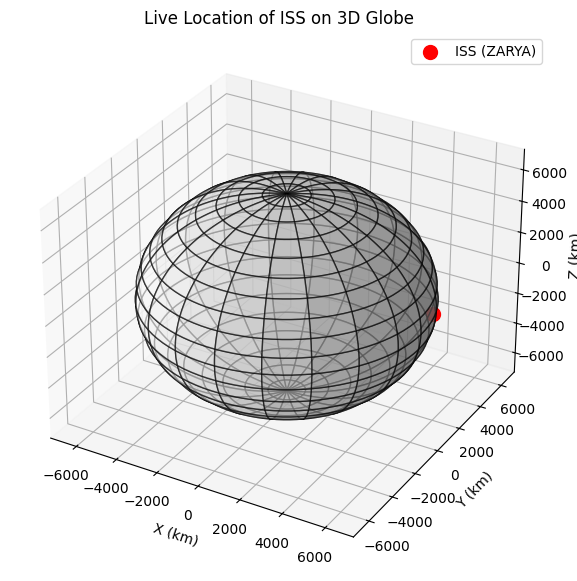

<ipython-input-12-61e0804aa7cd>:124: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=1000, blit=True)


TypeError: Path3DCollection.set_3d_properties() takes 3 positional arguments but 4 were given

In [12]:
from re import S
from skyfield.api import Topos, load
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
from astropy.table import Table

# Load TLE data
tle_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=stations&FORMAT=tle'
satellites = load.tle_file(tle_url)
satellite = {sat.name: sat for sat in satellites}['ISS (ZARYA)']


Satellite_cords =[]
for sat in satellites:
    earth_radius = 6371
    ts = load.timescale()
    t = ts.now()
    subpoint = sat.at(t).subpoint()
    latitude, longitude = subpoint.latitude.degrees, subpoint.longitude.degrees
    sat_lat_rad = np.radians(latitude)
    sat_lon_rad = np.radians(longitude)
    sat_x = earth_radius * np.cos(sat_lat_rad) * np.cos(sat_lon_rad)
    sat_y = earth_radius * np.cos(sat_lat_rad) * np.sin(sat_lon_rad)
    sat_z = earth_radius * np.sin(sat_lat_rad)
    Satellite_cords.append({
        'Satellite Name': sat.name,
        'X': sat_x,
        'Y': sat_y,
        'Z': sat_z
    })

table = Table(rows=Satellite_cords)
table.write('Satellite_Cords.csv', format='csv', overwrite=True)

# Observer's location
observer = Topos(latitude_degrees=0, longitude_degrees=0)

# Compute satellite position
ts = load.timescale()
t = ts.now()
subpoint = satellite.at(t).subpoint()
latitude, longitude = subpoint.latitude.degrees, subpoint.longitude.degrees

# Set up a 3D globe plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a sphere for the Earth
def create_sphere(radius):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
    return x, y, z

# Earth parameters
earth_radius = 6371  # in kilometers
x, y, z = create_sphere(earth_radius)

# Plot the Earth
ax.plot_surface(x, y, z, rstride=5, cstride=5, color='w', alpha=0.6, edgecolor='k')

# Convert satellite position to 3D coordinates
sat_lat_rad = np.radians(latitude)
sat_lon_rad = np.radians(longitude)
sat_x = earth_radius * np.cos(sat_lat_rad) * np.cos(sat_lon_rad)
sat_y = earth_radius * np.cos(sat_lat_rad) * np.sin(sat_lon_rad)
sat_z = earth_radius * np.sin(sat_lat_rad)

# Plot the satellite
satellite_point = ax.scatter(sat_x, sat_y, sat_z, color='r', s=100, label='ISS (ZARYA)')

# Labels and legend
ax.set_title('Live Location of ISS on 3D Globe')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()

# Show the plot
plt.savefig('ISS ZARYA Location.png')
plt.show()

# trail_X = []
# trail_Y = []
# trail_Z = []

# def update(frame):
#     global trail_X, trail_Y, trail_Z
#     t = ts.now()
#     geocentric = satellite.at(t)
#     subpoint = geocentric.subpoint()
#     latitude, longitude = subpoint.latitude.degrees, subpoint.longitude.degrees
#     sat_lat_rad = np.radians(latitude)
#     sat_lon_rad = np.radians(longitude)
#     sat_x = earth_radius * np.cos(sat_lat_rad) * np.cos(sat_lon_rad)
#     sat_y = earth_radius * np.cos(sat_lat_rad) * np.sin(sat_lon_rad)
#     sat_z = earth_radius * np.sin(sat_lat_rad)

#     # Update trail data
#     # trail_longitudes.append(longitude)
#     # trail_latitudes.append(latitude)
#     trail_X.append(sat_x)
#     trail_Y.append(sat_y)
#     trail_Z.append(sat_z)

#     # Keep trail data within a reasonable length
#     if len(trail_X) > 10:
#         trail_Y.pop(0)
#         trail_X.pop(0)
#         trail_Z.pop(0)

#     # Update plot data
#     # satellite_point.set_data(sat_x, sat_y)
#     satellite_point.set_3d_properties(sat_x, sat_y, sat_z)

#     return satellite_point

# # Set up animation
# ani = FuncAnimation(fig, update, interval=1000, blit=True)

# ani.save('Satellite.mp4',
#           writer = 'ffmpeg', fps = 30)
